# Overview 
The data extraction code snippet is for [Master Plan 2019 Subzones Boundary](https://data.gov.sg/dataset/master-plan-2019-subzone-boundary-no-sea) from data.gov.sg.

Please download the dataset from the hyperlink text before running the code below.

In [1]:
import geopandas as gpd 
import pandas as pd 
subzones_gdf = gpd.read_file('data//master-plan-2019-subzone-boundary-no-sea-geojson.geojson')


subzones_gdf.head(1)

,Name,Description,geometry
0,kml_1,<center><table><tr><th colspan='2' align='cent...,"POLYGON Z ((103.88025 1.28386 0.00000, 103.880..."


In [2]:
description_dict_list = []
for d in subzones_gdf.Description:
    html_df = pd.read_html(d)[0]
    col_key = html_df.Attributes
    col_values = html_df['Attributes.1']
    description_dict = dict(zip(col_key, col_values))
    description_dict_list.append(description_dict)
description_df = pd.DataFrame(description_dict_list)
description_df.head(3)

,SUBZONE_NO,SUBZONE_N,SUBZONE_C,CA_IND,PLN_AREA_N,PLN_AREA_C,REGION_N,REGION_C,INC_CRC,FMEL_UPD_D
0,1,MARINA EAST,MESZ01,Y,MARINA EAST,ME,CENTRAL REGION,CR,4FB7E5B1B9455DE0,20191223152313
1,5,INSTITUTION HILL,RVSZ05,Y,RIVER VALLEY,RV,CENTRAL REGION,CR,C3C22D1EE31757BD,20191223152313
2,1,ROBERTSON QUAY,SRSZ01,Y,SINGAPORE RIVER,SR,CENTRAL REGION,CR,87306ABAF4B67E2E,20191223152313


<strong>Do note that SUBZONE_NO is not a unique field.</strong>

In [3]:
subzones_processed_gdf = subzones_gdf.join(description_df, how='left')
subzones_processed_gdf.drop(['Description'], axis=1, inplace=True)
subzones_processed_gdf.sample(1)

,Name,geometry,SUBZONE_NO,SUBZONE_N,SUBZONE_C,CA_IND,PLN_AREA_N,PLN_AREA_C,REGION_N,REGION_C,INC_CRC,FMEL_UPD_D
117,kml_118,"POLYGON Z ((103.84194 1.31095 0.00000, 103.841...",3,NEWTON CIRCUS,NTSZ03,Y,NEWTON,NT,CENTRAL REGION,CR,AB6C665F6F6FE010,20191223152313


## Creating a Singapore Merged Polygon 
We will also create a merged polygon shape out of the subzones to create a map of Singapore. A merged polygon map of a country could be useful in subsequent geospatial join or in obtaining bounded values to be used in geospatial queries. However, do note that the merged polygon contains islands. If you want a land-docked version of Singapore without islands, you would need to use a geospatial tool to manually remove the island. 

In [4]:
from shapely.ops import unary_union
from shapely.geometry import MultiPolygon, Polygon
import geojson
## Create a merged map (including island)
singapore_map = unary_union(subzones_processed_gdf.geometry)
singapore_map_gdf = gpd.GeoSeries([singapore_map])
singapore_map_geojson = singapore_map_gdf.__geo_interface__

In [5]:
## write file 
subzones_processed_gdf.to_file('data//subzones_2019.geojson' , driver='GeoJSON')
singapore_map_gdf.to_file('data//singapore_map.geojson' , driver='GeoJSON')


## Breaking down subzones multipolygon file into polygon to enable edit of file
If you would like to remove the island, you would need to break down the multipolygons into single polygons. This is to allow you to easily remove the non-land connecting islands.

In [6]:
subzones_processed_gdf.loc[:, 'multipolygon'] = subzones_processed_gdf.geometry.apply(lambda x: True if type(x) == MultiPolygon else False)
subzones_multipolygon = subzones_processed_gdf[subzones_processed_gdf.multipolygon == True].copy()
subzones_polygon = subzones_processed_gdf[subzones_processed_gdf.multipolygon == False].copy()
subzones_processed_gdf.drop(['multipolygon'], axis=1, inplace=True)
subzones_multipolygon.drop(['multipolygon'], axis=1, inplace=True)
subzones_polygon.drop(['multipolygon'], axis=1, inplace=True)


In [7]:
base_col = [ i for i in subzones_processed_gdf.columns if i != 'geometry']
polygon_df_list = []
for ind in subzones_multipolygon.index:
    row_geom = subzones_multipolygon.loc[ind, 'geometry']
    for i, p in enumerate(row_geom):
        base_row = subzones_multipolygon.loc[ind, base_col]
        base_row['Name'] = base_row['Name'] + '_' + str(i) 
        base_row['geometry'] = Polygon(p)
        base_df = base_row.to_frame().T 
        polygon_df_list.append(base_df)

subzones_multipolygon_explode = pd.concat(polygon_df_list)
subzones_multipolygon_explode.head(2)

,Name,SUBZONE_NO,SUBZONE_N,SUBZONE_C,CA_IND,PLN_AREA_N,PLN_AREA_C,REGION_N,REGION_C,INC_CRC,FMEL_UPD_D,geometry
3,kml_4_0,1,JURONG ISLAND AND BUKOM,WISZ01,N,WESTERN ISLANDS,WI,WEST REGION,WR,C87E378D3456FC35,20191223152313,POLYGON Z ((103.712533924434 1.29162539096911 ...
3,kml_4_1,1,JURONG ISLAND AND BUKOM,WISZ01,N,WESTERN ISLANDS,WI,WEST REGION,WR,C87E378D3456FC35,20191223152313,POLYGON Z ((103.750699899398 1.23571844319944 ...


In [8]:
## combine exploded polygon back into polygon 
subzones_polygon_exploded = pd.concat([subzones_polygon, subzones_multipolygon_explode])
subzones_polygon_exploded.reset_index(inplace=True, drop=True)
subzones_polygon_exploded.head(2)


,Name,geometry,SUBZONE_NO,SUBZONE_N,SUBZONE_C,CA_IND,PLN_AREA_N,PLN_AREA_C,REGION_N,REGION_C,INC_CRC,FMEL_UPD_D
0,kml_1,"POLYGON Z ((103.88025 1.28386 0.00000, 103.880...",1,MARINA EAST,MESZ01,Y,MARINA EAST,ME,CENTRAL REGION,CR,4FB7E5B1B9455DE0,20191223152313
1,kml_2,"POLYGON Z ((103.83764 1.29560 0.00000, 103.837...",5,INSTITUTION HILL,RVSZ05,Y,RIVER VALLEY,RV,CENTRAL REGION,CR,C3C22D1EE31757BD,20191223152313


In [10]:
subzones_polygon_exploded.to_file('data//subzones_polygon_2019.geojson' , driver='GeoJSON')

## Editing the subzone polygon file with QGIS
Now that the file format is in polygon, we are able to edit the singapore map to our preferred form. The GIS tool that i am using is QGIS. There are also many other tools out there that you can explore. As the editted file format is too big. I will only be sharing the merged polygon file outside, which will be the singapore_map_inland.geojson.

In [12]:
subzones_inland = gpd.read_file('data//subzone_polygon_inland.gpkg')
singapore_map_inland = unary_union(subzones_inland.geometry)
singapore_map_inland_gdf = gpd.GeoSeries([singapore_map_inland])
singapore_map_inland_gdf


0    POLYGON Z ((103.64765 1.28960 0.00000, 103.647...
dtype: geometry

In [13]:
singapore_map_inland_gdf.to_file('singapore_map_inland.geojson' , driver='GeoJSON')

## Illustration of inland vs original map

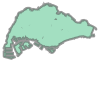

In [14]:
singapore_map_inland

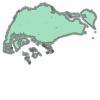

In [15]:
singapore_map